In [2]:
from typing import List, TypedDict, Literal
from pydantic import BaseModel, Field
import time

from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate

from langgraph.graph import StateGraph, START, END
from dotenv import load_dotenv

load_dotenv()

True

In [3]:
docs = (
    PyPDFLoader("C:\\Users\\PMYLS\\Desktop\\Gen-AI\\LangGraph\\self_RAG\\documents\\Company_Policies.pdf").load()
    + PyPDFLoader("C:\\Users\\PMYLS\\Desktop\\Gen-AI\\LangGraph\\self_RAG\\documents\\Company_Profile.pdf").load()
    + PyPDFLoader("C:\\Users\\PMYLS\\Desktop\\Gen-AI\\LangGraph\\self_RAG\\documents\\Product_and_Pricing.pdf").load()
)

In [4]:
chunks = RecursiveCharacterTextSplitter(
    chunk_size=600, chunk_overlap=150
).split_documents(docs)

In [5]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
vector_store = FAISS.from_documents(chunks, embeddings)
retriever = vector_store.as_retriever(search_kwargs={"k": 4})

In [6]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [7]:
# --------------------------------------------------
# Graph State
# --------------------------------------------------
class State(TypedDict):
    question: str
    need_retrieval: bool

    docs: List[Document]
    relevant_docs: List[Document]     

    context: str # New
    answer: str

In [8]:
class RetrieveDecision(BaseModel):
    should_retrieve: bool = Field(
        ...,
        description="True if external documents are needed to answer reliably, else False."
    )

decide_retrieval_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You decide whether retrieval is needed.\n"
            "Return JSON that matches this schema:\n"
            "{{'should_retrieve': boolean}}\n\n"
            "Guidelines:\n"
            "- should_retrieve=True if answering requires specific facts, citations, or info likely not in the model.\n"
            "- should_retrieve=False for general explanations, definitions, or reasoning that doesn't need sources.\n"
            "- If unsure, choose True."
        ),
        ("human", "Question: {question}"),
    ]
)


# IMPORTANT: no `.content` for structured output
should_retrieve_llm = llm.with_structured_output(RetrieveDecision)

import json
import ast

def decide_retrieval(state: "State"):
    prompt = decide_retrieval_prompt.format_prompt(question=state["question"])
    response = llm.invoke(prompt)
    content = response.content.strip()
    print("LLM response:", content)  # Debug print

    try:
        return {"need_retrieval": json.loads(content)["should_retrieve"]}
    except Exception:
        try:
            return {"need_retrieval": ast.literal_eval(content)["should_retrieve"]}
        except Exception:
            # Handle 'should_retrieve: True' or similar
            if "True" in content:
                return {"need_retrieval": True}
            elif "False" in content:
                return {"need_retrieval": False}
            else:
                raise ValueError("Could not parse LLM output: " + content)

In [9]:
direct_generation_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Answer the question using only your general knowledge.\n"
            "Do NOT assume access to external documents.\n"
            "If you are unsure or the answer requires specific sources, say:\n"
            "'I don't know based on my general knowledge.'"
        ),
        ("human", "{question}"),
    ]
)


def generate_direct(state: State):
    out = llm.invoke(
        direct_generation_prompt.format_messages(
            question=state["question"]
        )
    )
    return {
        "answer": out.content
    }

In [10]:
def retrieve(state: State):
    return {"docs": retriever.invoke(state["question"])}

In [11]:
class RelevanceDecision(BaseModel):
    is_relevant: bool = Field(
        ...,
        description="True if the document helps answer the question, else False."
    )

is_relevant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are judging document relevance.\n"
            "Return JSON that matches this schema:\n"
            "{{'is_relevant': boolean}}\n\n"
            "A document is relevant if it contains information useful for answering the question."
        ),
        (
            "human",
            "Question:\n{question}\n\nDocument:\n{document}"
        ),
    ]
)

relevance_llm = llm.with_structured_output(RelevanceDecision)

def is_relevant(state: State):
    relevant_docs: List[Document] = []
    for doc in state["docs"]:
        prompt = is_relevant_prompt.format_prompt(
            question=state["question"],
            document=doc.page_content
        )
        response = llm.invoke(prompt)
        content = response.content.strip()
        print("LLM response:", content)  # Debug print

        try:
            decision = json.loads(content)
        except Exception:
            # Try to fix common issues
            content_fixed = content.replace("'", "\"")
            if content_fixed.startswith("{") and content_fixed.endswith("}"):
                try:
                    decision = json.loads(content_fixed)
                except Exception:
                    decision = None
            else:
                # Handle 'is_relevant: True' or similar
                if "True" in content or "False" in content:
                    val = "True" in content
                    decision = {"is_relevant": val}
                else:
                    decision = None

        if decision and decision.get("is_relevant"):
            relevant_docs.append(doc)
    return {"relevant_docs": relevant_docs}

In [12]:
# New
rag_generation_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a business RAG assistant.\n"
            "Answer the user's question using ONLY the provided context.\n"
            "If the context does not contain enough information, say:\n"
            "'No relevant document found.'\n"
            "Do not use outside knowledge.\n"
        ),
        (
            "human",
            "Question:\n{question}\n\n"
            "Context:\n{context}\n"
        ),
    ]
)

def generate_from_context(state: State):
    # Stuff relevant docs into one block
    context = "\n\n---\n\n".join(
        [d.page_content for d in state.get("relevant_docs", [])]
    ).strip()

    if not context:
        return {"answer": "No relevant document found.", "context": ""}

    out = llm.invoke(
        rag_generation_prompt.format_messages(
            question=state["question"],
            context=context
        )
    )
    return {"answer": out.content, "context": context}

In [13]:
# New
def no_relevant_docs(state: State):
    return {"answer": "No relevant document found.", "context": ""}

In [14]:
def route_after_decide(state: State) -> Literal["generate_direct", "retrieve"]:
    if state["need_retrieval"]:
        return "retrieve"
    return "generate_direct"

In [15]:
# New
def route_after_relevance(state: State) -> Literal["generate_from_context", "no_relevant_docs"]:
    if state.get("relevant_docs") and len(state["relevant_docs"]) > 0:
        return "generate_from_context"
    return "no_relevant_docs"

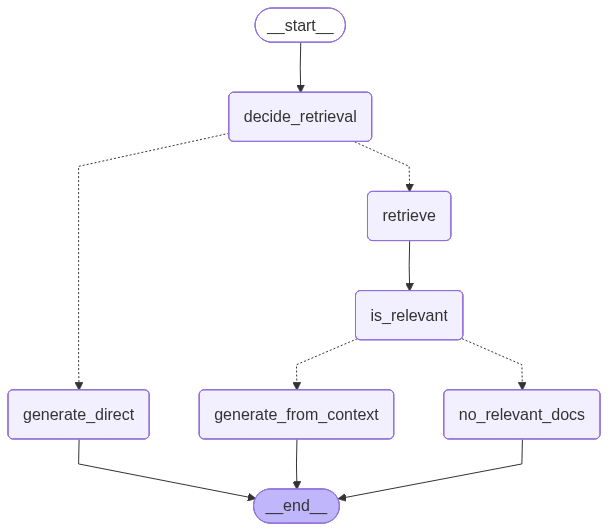

In [16]:
g = StateGraph(State)

g.add_node("decide_retrieval", decide_retrieval)
g.add_node("generate_direct", generate_direct)
g.add_node("retrieve", retrieve)
g.add_node("is_relevant", is_relevant)
g.add_node("generate_from_context", generate_from_context)
g.add_node("no_relevant_docs", no_relevant_docs)

g.add_edge(START, "decide_retrieval")

g.add_conditional_edges(
    "decide_retrieval",
    route_after_decide,
    {
        "generate_direct": "generate_direct",
        "retrieve": "retrieve",
    },
)

g.add_edge("generate_direct", END)

g.add_edge("retrieve", "is_relevant")

g.add_conditional_edges(
    "is_relevant",
    route_after_relevance,
    {
        "generate_from_context": "generate_from_context",
        "no_relevant_docs": "no_relevant_docs",
    },
)

g.add_edge("generate_from_context", END)
g.add_edge("no_relevant_docs", END)

app = g.compile()

app

In [17]:
result = app.invoke(
    {
        "question": "Who is CEO NexaAI",
        "docs": [],
        "relevant_docs": [],
        "context": "",
        "answer": "",
    }
)

print(result["answer"])

LLM response: {'should_retrieve': True}
LLM response: {
  "is_relevant": true
}
LLM response: {'is_relevant': False}
LLM response: {'is_relevant': False}
LLM response: {'is_relevant': False}
The CEO of NexaAI is Aarav Mehta.
